In [1]:
# generic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# notebook settings
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2 
# precision and plot settings
num_precision = 3
np.set_printoptions(precision=num_precision, suppress=True)
pd.set_option('display.float_format', lambda x: f'{x:,.{num_precision}f}')
pd.set_option("display.precision", num_precision)
pd.set_option('display.max_columns', None)

plt.style.use('tableau-colorblind10')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['lines.linewidth'] = 2

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
# setup dir and import helper functions
import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'src'))
import helper_funcs as my_funcs

In [4]:
# load model to run predictions
model = keras.models.load_model('../data/500_epochs_model_wild_est_binary')

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      8

In [6]:
directory = '../data/sat_images/wild_est/'
img_size = 256
batch_size = 32

In [7]:
# or load the colab versions
# from tensorflow.data.experimental import load
# from tensorflow import TensorSpec, float32, int32
# elem_spec = (TensorSpec(shape=(None, 256, 256, 3), dtype=float32, name=None), TensorSpec(shape=(None,), dtype=int32, name=None))

# X_train_data_path = '/Users/pault/CSUgoogledrive/TF_datasets/X_train'
# X_test_data_path = '/Users/pault/CSUgoogledrive/TF_datasets/X_test'
# X_train = load(X_train_data_path, element_spec=elem_spec, compression='GZIP', reader_func=None)
# X_test = load(X_test_data_path, element_spec=elem_spec, compression='GZIP', reader_func=None)

In [13]:
# load original data
X_train = image_dataset_from_directory(
    directory, labels='inferred', class_names=None,
    color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=True, seed=42,
    validation_split=0.2, subset='training', interpolation='bilinear', follow_links=True
)

X_test = image_dataset_from_directory(
    directory, labels='inferred', class_names=None, 
    color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=False, seed=42, 
    validation_split=0.2, subset='validation', interpolation='bilinear', follow_links=True
)

Found 16232 files belonging to 2 classes.
Using 12986 files for training.
Found 16232 files belonging to 2 classes.
Using 3246 files for validation.


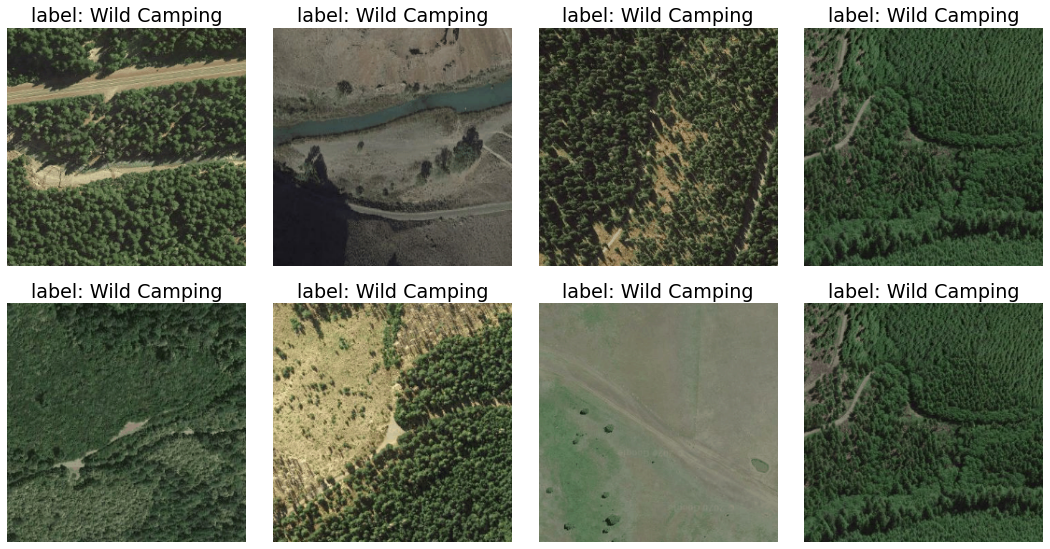

In [14]:
num_samples = 10
figsize = (15,8)
my_funcs.plot_example_imgs(X_test, figsize, num_samples);
# plt.savefig('../images/example_imgs.png') 

In [8]:
y, predictions, y_pred, y_pred_bin, fpr_keras, tpr_keras, thresholds_keras, auc_keras = my_funcs.run_model(model, X_test)

102/102 - 27s


In [9]:
#model.evaluate(X_test)

In [9]:
print(classification_report(y, y_pred_bin))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1103
           1       0.87      0.96      0.91      2143

    accuracy                           0.88      3246
   macro avg       0.88      0.84      0.86      3246
weighted avg       0.88      0.88      0.88      3246



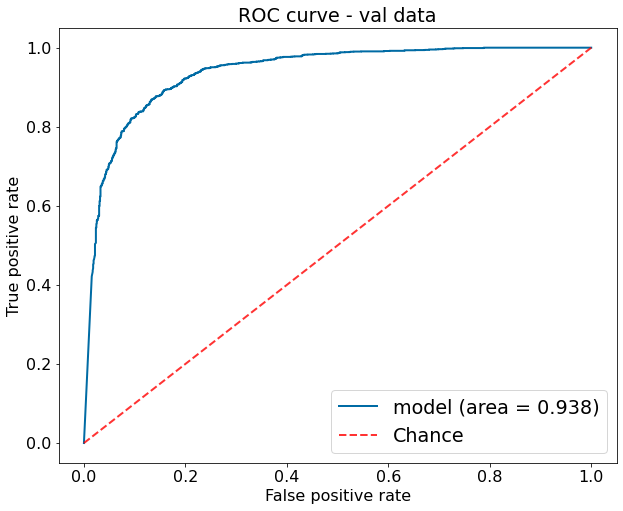

In [10]:
# https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
fig, ax = plt.subplots(1, figsize=(10, 8))
ax = my_funcs.get_ROC_plot(ax, fpr_keras, tpr_keras, auc_keras, 'ROC curve - val data')
#plt.show()
# plt.savefig('../images/ROC_500epochs_newdata_ID_NM_MT_fixed.png') 

In [11]:
confmat = my_funcs.compute_confusion_matrix(y, y_pred_bin)
confmat

array([[0.893, 0.127],
       [0.107, 0.873]])

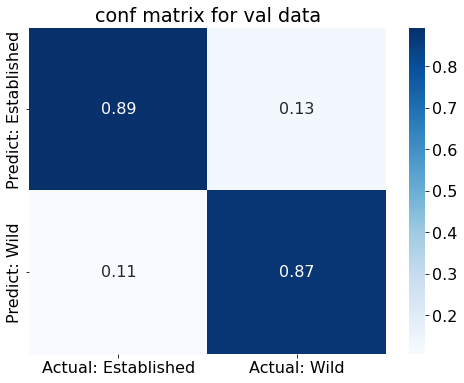

In [12]:
x_labels = ['Predict: Established', 'Predict: Wild'] 
y_labels = ['Actual: Established', 'Actual: Wild']

fig, ax = plt.subplots(1, figsize = (8,6))
ax = my_funcs.plot_conf_matrix(confmat, ax, x_labels, y_labels, 'conf matrix for val data')
#plt.savefig('../images/conf_matrix_final.png')

In [15]:
# load test data
directory = '../data/sat_images/wild_est_new_data/'
new_test = image_dataset_from_directory(
    directory, labels='inferred', class_names=None, 
    color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=False, seed=42,
    validation_split=0, interpolation='bilinear', follow_links=True
)

Found 3684 files belonging to 2 classes.


In [16]:
y, predictions, y_pred, y_pred_bin, fpr_keras, tpr_keras, thresholds_keras, auc_keras = my_funcs.run_model(model, new_test)

116/116 - 51s


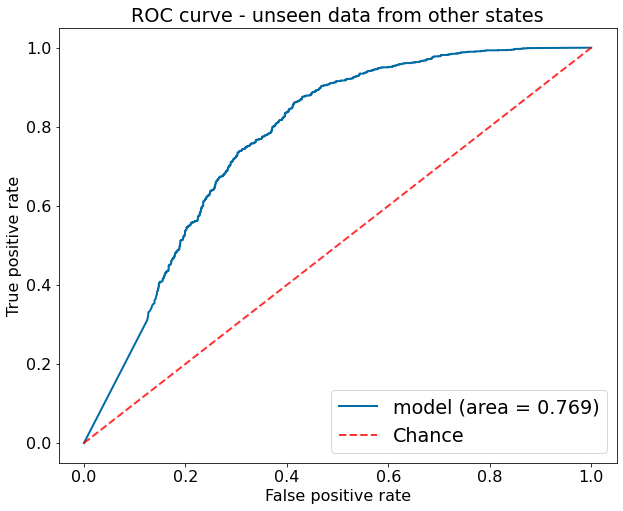

In [17]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax = my_funcs.get_ROC_plot(ax, fpr_keras, tpr_keras, auc_keras, 'ROC curve - unseen data from other states')
#plt.savefig('../images/conf_matrix_final.png')

In [18]:
confmat = my_funcs.compute_confusion_matrix(y, y_pred_bin)
confmat

array([[0.795, 0.305],
       [0.205, 0.695]])

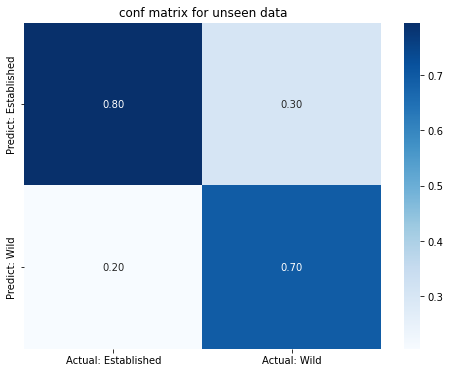

In [24]:
fig, ax = plt.subplots(1, figsize = (8,6))
x_labels = ['Predict: Established', 'Predict: Wild'] 
y_labels = ['Actual: Established', 'Actual: Wild']
ax = my_funcs.plot_conf_matrix(confmat, ax, x_labels, y_labels, 'conf matrix for unseen data')
#plt.savefig('../images/conf_matrix_final.png')

In [20]:
y_predictions_df = my_funcs.get_imgs_into_df(X_test, y, y_pred_bin)

In [21]:
wrong_imgs = y_predictions_df[y_predictions_df['predict'] != y_predictions_df['actual']]

In [22]:
wrong_imgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 4 to 3571
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   predict  998 non-null    object
 1   actual   998 non-null    object
 2   image    969 non-null    object
dtypes: object(3)
memory usage: 31.2+ KB


In [ ]:
np.diag(np.fliplr(confmat)).sum()

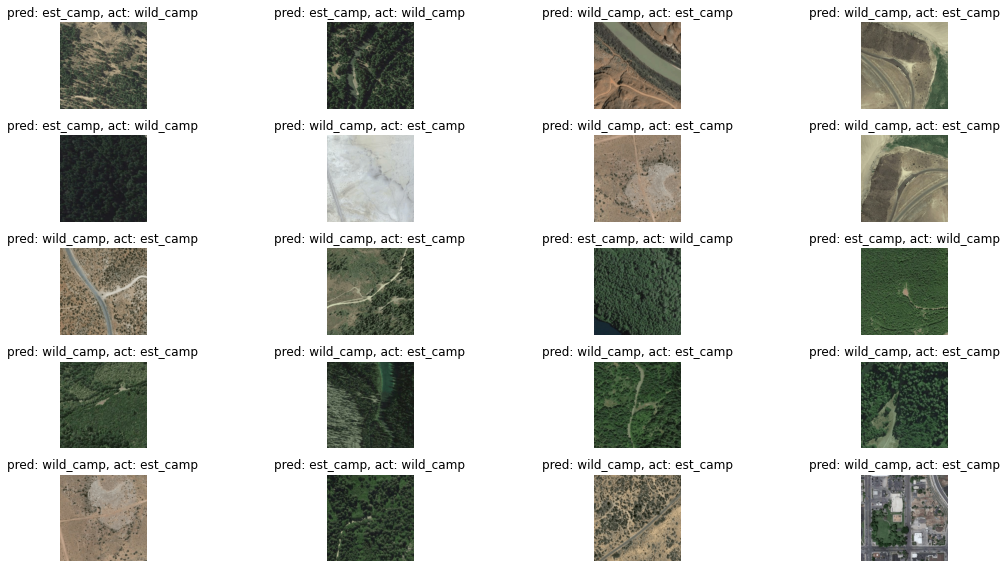

In [23]:
# plot some
num_samples = 20
figsize = (15,8)
fig, axs = my_funcs.plot_wrong_imgs(wrong_imgs, figsize, num_samples)
#plt.savefig('../images/conf_matrix_final.png')